# Fig1_PN_ORN_Heatmaps

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
#Load data and libs
df_logCPM_all = pd.read_csv("../data/htseq_logCPM_hq.tab.gz", sep="\t", header=0, index_col=0) # CPM

In [3]:
df_libs = pd.read_csv("../data/libs_color3.csv", sep=",", header=0, index_col=0) # sample info

In [4]:
df_libs = pd.read_csv("../data/libs_color3_batch.csv", sep=",", header=0, index_col=0) # sample info

# Filter for ORNs and PNs

In [5]:
# Load names of high quality neurons (3/6 markers), cutoff 
names_hq_neurons = []
with open ("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())
        
# Get names of GH146+ PNs
selector = ((df_libs["genotype"] == "GH146-GFP") & (df_libs["num_cells"] ==1))
names_PN = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]
print "PNs", len(names_PN)

# Get names of ORNs
selector0 = (df_libs["label"] == "nSyb_48h_ORN_P0") 
selector1 = (df_libs["label"] == "nSyb_48h_ORN_P1")
selector2 = (df_libs["label"] == "nSyb_48h_ORN_P2")
selector3 = (df_libs["label"] == "nSyb_48h_ORN_P4")
names_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector0].index) 
                      or (x in df_libs.loc[selector1].index) 
                      or (x in df_libs.loc[selector2].index)
                      or (x in df_libs.loc[selector3].index))
                      and x in names_hq_neurons]
print "ORN", len(names_ORN)

# Get names new P4 85A10_ORNs
selector = (df_libs["label"] == "85A10_48h_ORN_P4") 
names_85A10_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector].index) and x in names_hq_neurons)]
print "New_85A10_ORN_P4", len(names_85A10_ORN)

# Get names AM29_ORNs
selector = (df_libs["label"] == "Am29_48h_ORN_P4") 
names_AM29_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector].index) and x in names_hq_neurons)]
print "AM29_ORN", len(names_AM29_ORN)

PNs 976
ORN 908
New_85A10_ORN_P4 63
AM29_ORN 45


In [6]:
# Filter for these cells
names_PN_nsyb_ORN = names_PN + names_ORN 
names_All_ORN = names_ORN + names_85A10_ORN +names_AM29_ORN
names_PN_All_ORN = names_PN + names_All_ORN

df_PN = df_logCPM_all[list(names_PN)]
df_PN_ORN = df_logCPM_all[list(names_PN_All_ORN)]
df_All_ORN = df_logCPM_all[list(names_All_ORN)]

df_AM29_ORN = df_logCPM_all[list(names_AM29_ORN)]
df_85A10_ORN = df_logCPM_all[list(names_85A10_ORN)]

print "PN:", df_PN.shape[1]
print "PN_All_ORN:", df_PN_ORN.shape[1]
print "ORN_All:", df_All_ORN.shape[1]
print "AM29_ORN:", df_AM29_ORN.shape[1]
print "85A10_ORN:", df_85A10_ORN.shape[1]

# Display number of cells of each genotype to confirm
#df_libs.loc[df.columns]["genotype"].value_counts()

PN: 976
PN_All_ORN: 1992
ORN_All: 1016
AM29_ORN: 45
85A10_ORN: 63


In [7]:
# Rename df for convenience
X_ORN = df_All_ORN
X_PN_ORN = df_PN_ORN
X_AM29_ORN = df_AM29_ORN
X_85A10_ORN = df_85A10_ORN

print "ORN:", X_ORN.shape[1]
print "AM29_ORN:", X_AM29_ORN.shape[1]
print "85A10_ORN:", X_85A10_ORN.shape[1]
print "PN_ORN_all:", X_PN_ORN.shape[1]

ORN: 1016
AM29_ORN: 45
85A10_ORN: 63
PN_ORN_all: 1992


# Selected genes to display - Overdispersed genes

In [8]:
df_libs = pd.read_csv("../data/libs_color3_PN_ORN.csv", sep=",", header=0, index_col=0) # sample info

In [12]:
# Get top overdispersed genes
myDispersion = sct.dispersion(X_PN_ORN)
myDispersion.calc_dispersion() # calculate overdispersion

genes_overdispersed = myDispersion.get_hits(N=1000) #top 100 genes

print genes_overdispersed.index

Index([u'Tsp42Ef', u'GstE4', u'zfh2', u'kn', u'unpg', u'Ir25a', u'GstS1',
       u'Hsp23', u'CG13578', u'Nep1',
       ...
       u'CG6398', u'CG32483', u'tilB', u'Hem', u'CG7386', u'l(1)G0045',
       u'CR33294', u'CG4462', u'CG3335', u'CG5955'],
      dtype='object', name=u'symbol', length=1000)


In [14]:
# Save overdispersed genes into files
with open("../data_paper/names_overdispersed_genes_PN_ORN_1000.txt", 'w') as out:
    for x in genes_overdispersed.index:
        out.write(x + "\n")

In [11]:
names_genes_overdispersed = []
with open ("../data_paper/names_overdispersed_genes_PN_ORN_1000.txt") as f:
    for line in f:
        names_genes_overdispersed.append(line.rstrip())
        
len(names_genes_overdispersed)

1000

In [14]:
# select N overdispersed genes
Z = X_PN_ORN.loc[names_genes_overdispersed[0:100]]
print Z.shape

(100, 1992)


[]

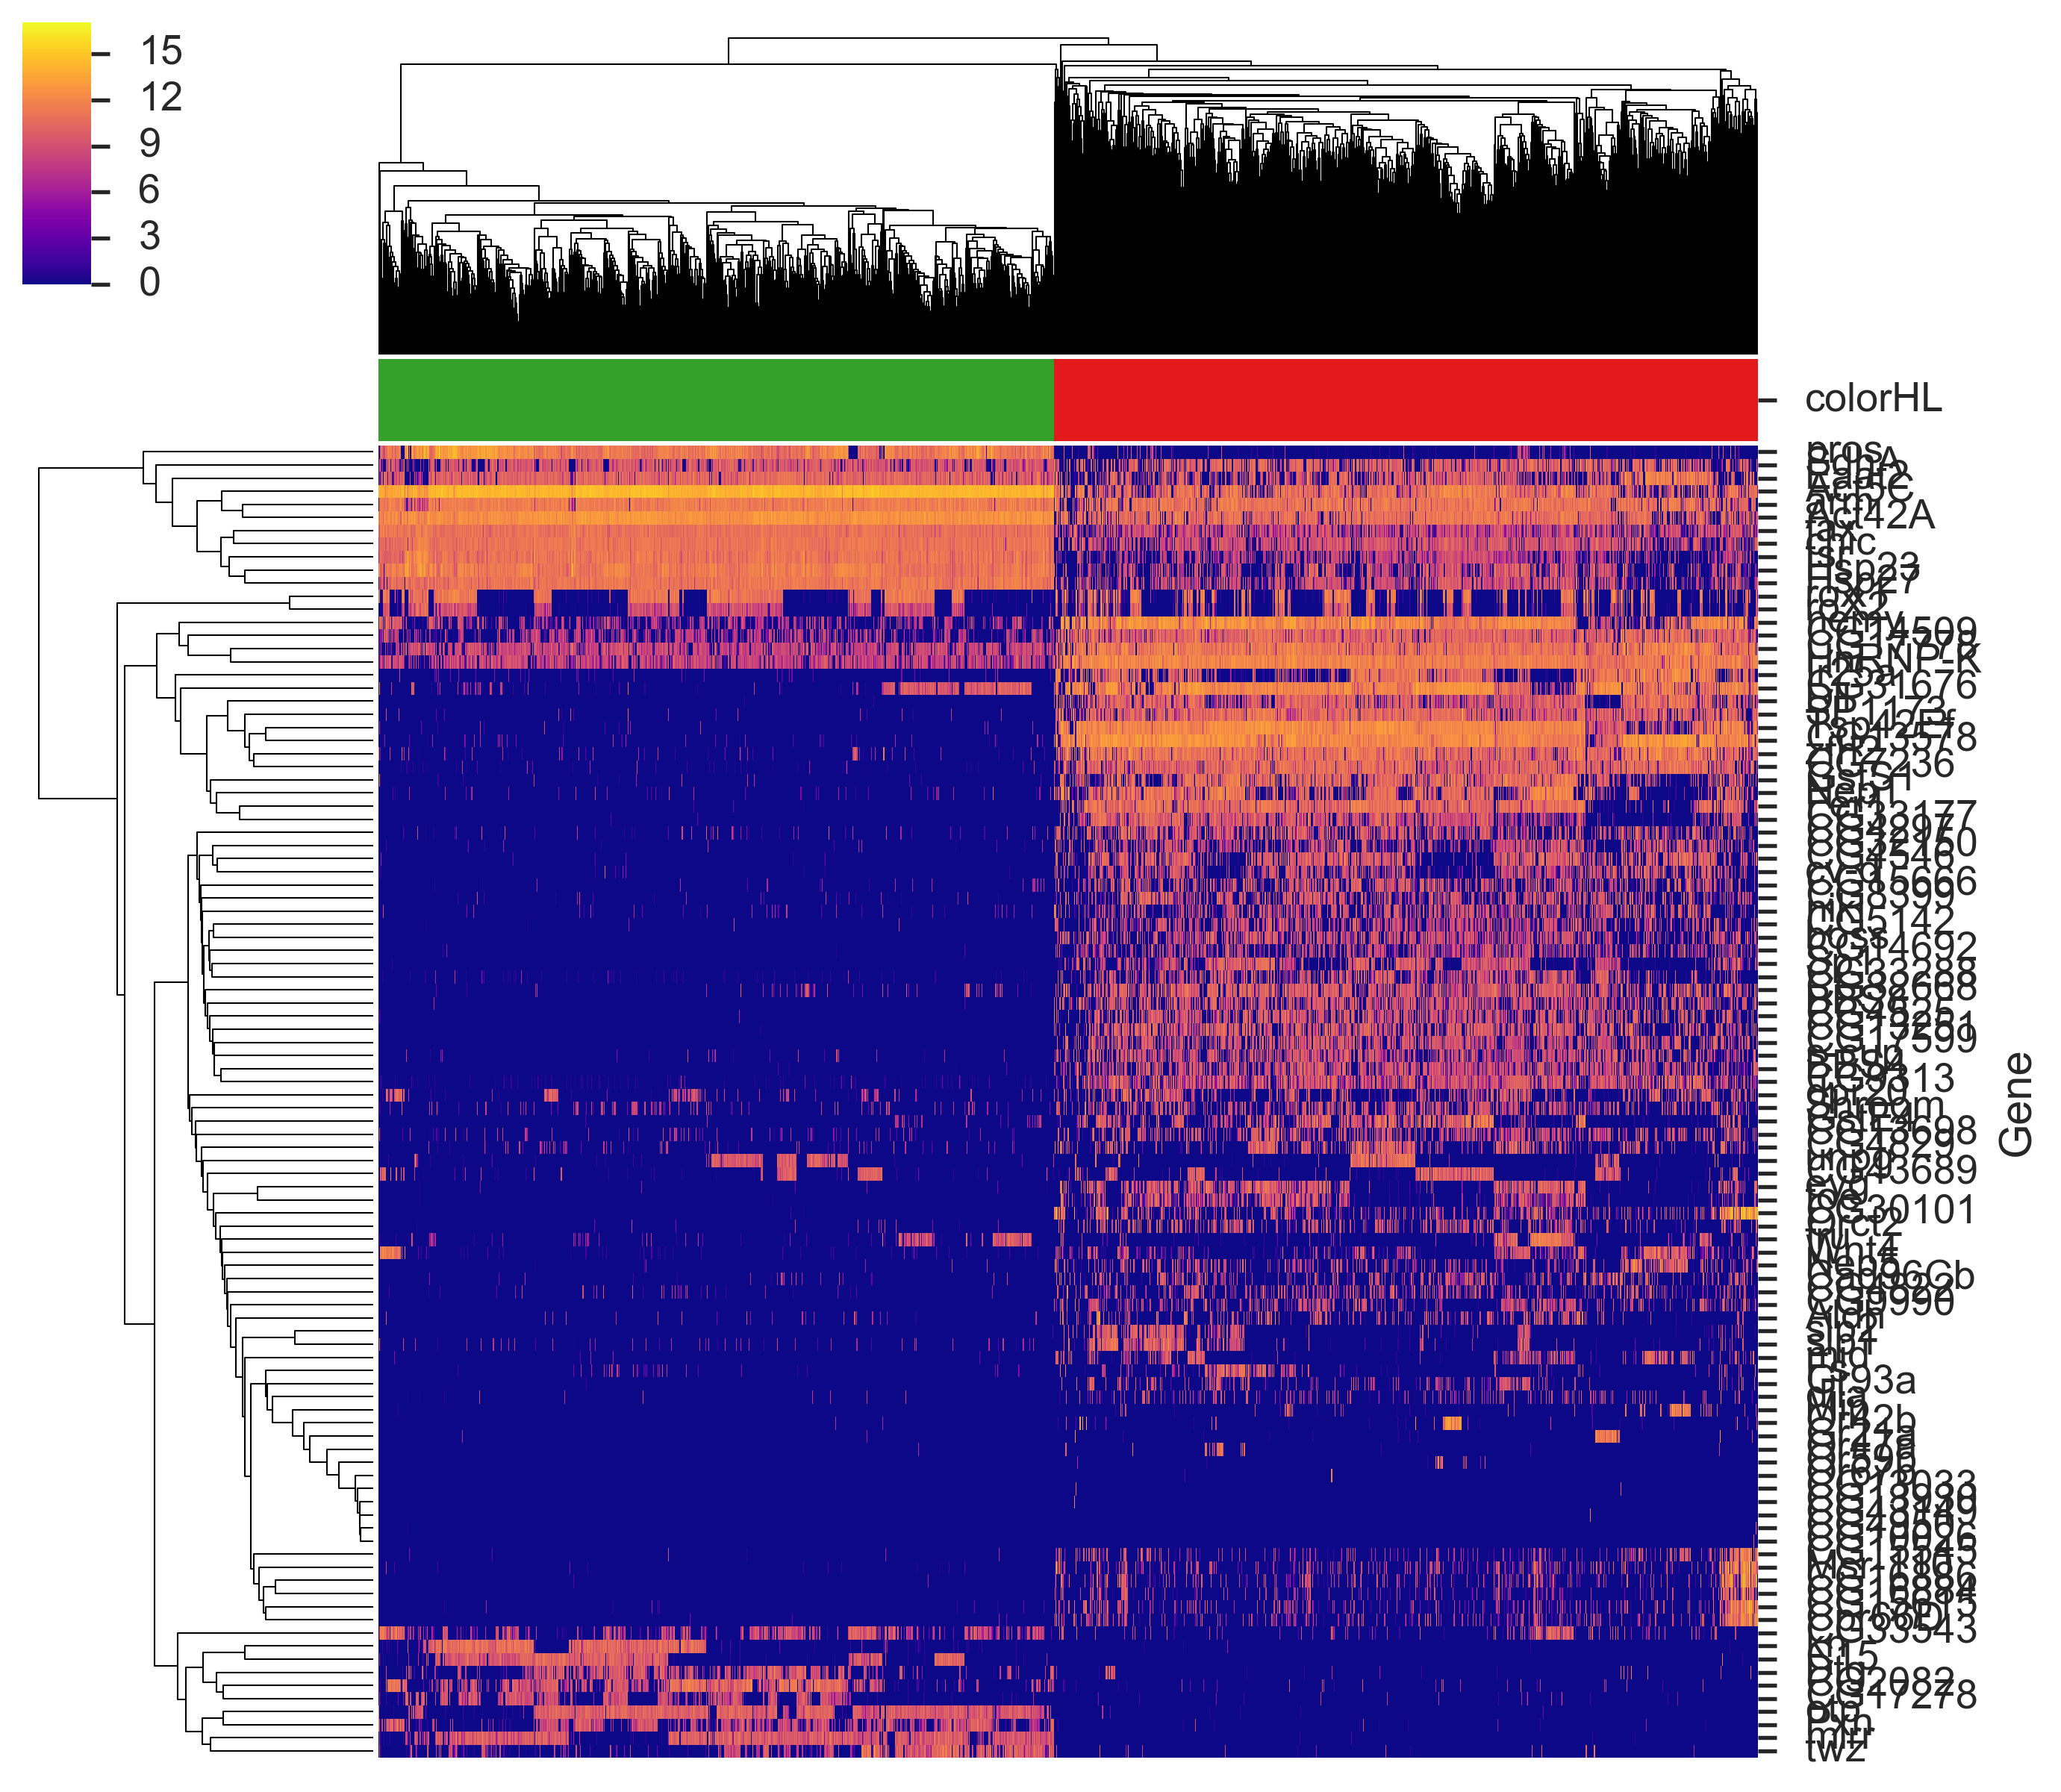

In [15]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,10), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
#cm.savefig("../HL_Figures_paper/Fig_1/Fig1_ORN_PN_ClusterMap_top_100_overdispersed_genes.pdf")

In [16]:
# select N overdispersed genes
Z = X_PN_ORN.loc[names_genes_overdispersed[0:500]]
print Z.shape

(500, 1992)


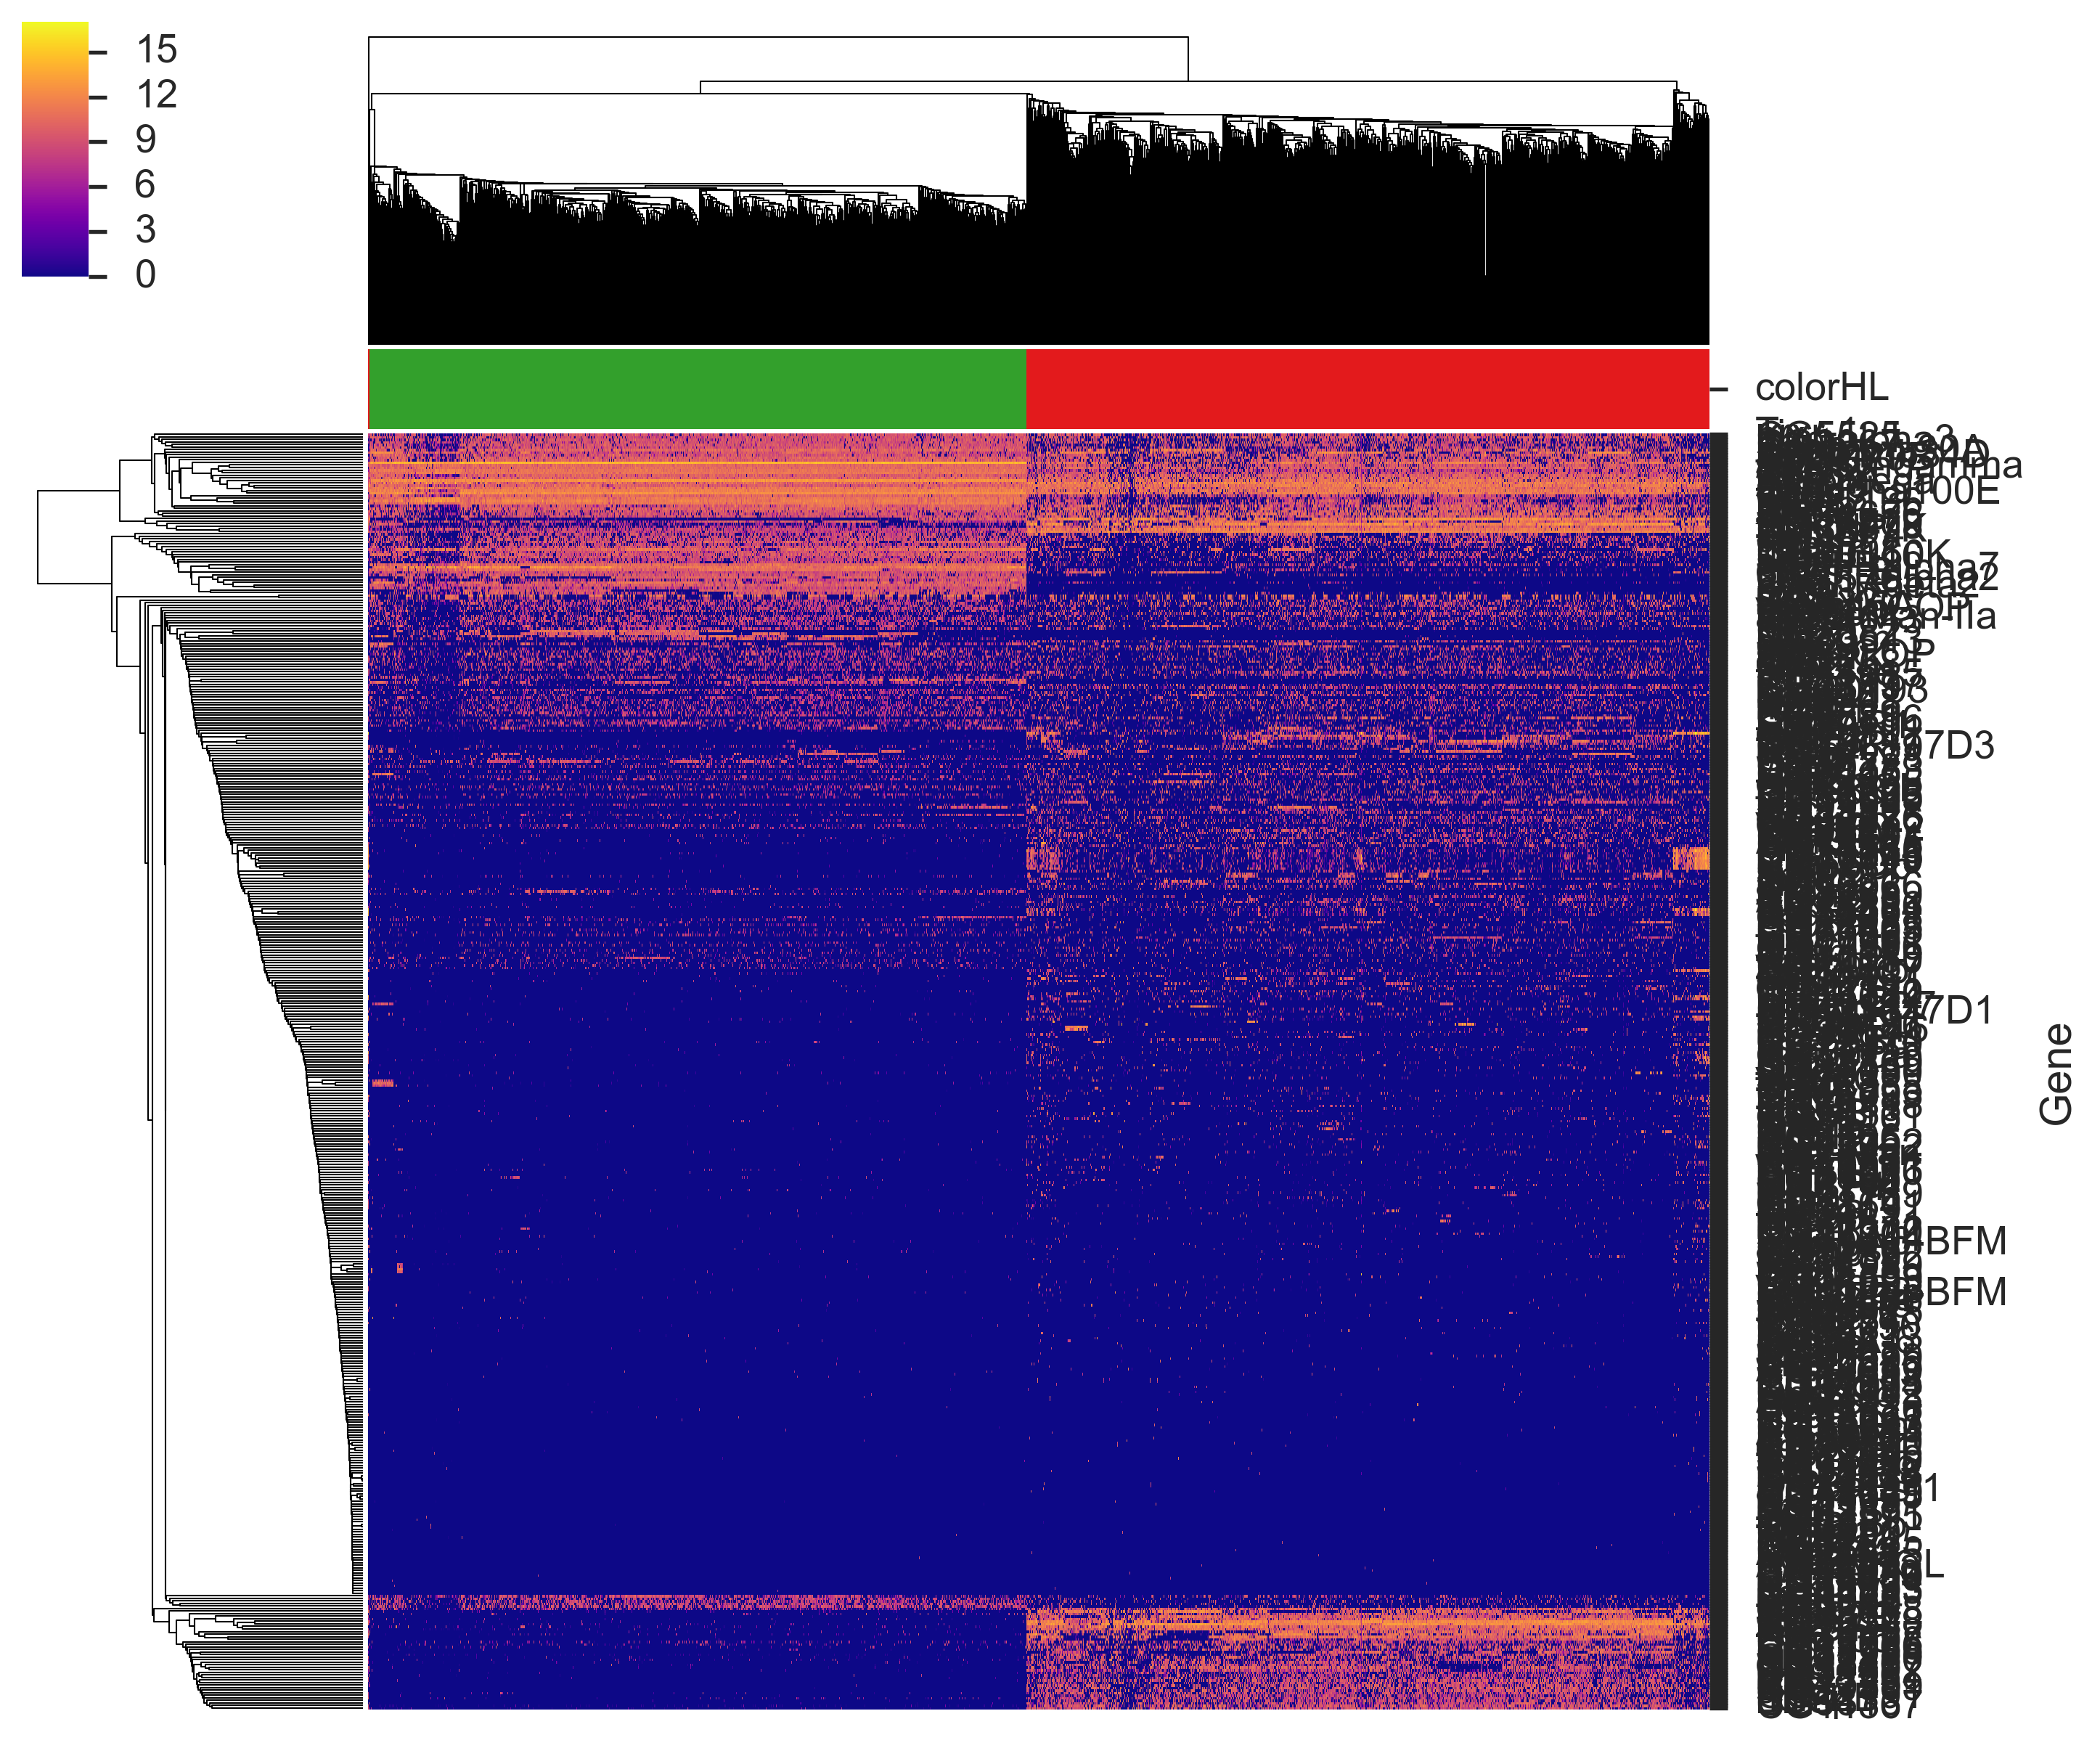

In [18]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,10), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../HL_Figures_paper/Fig_1/Fig1_ORN_PN_ClusterMap_top_500_overdispersed_genes.pdf")

# Selected genes to display - PN-ORN specific genes

In [22]:
X = X_PN_ORN
X.shape

(15908, 1992)

In [24]:
#This may take more than 10min
df_DE_ORN_PN = sct.calc_DE_mannwhitneyu(X, names_PN, names_New_ORN)


print "done!"

done!


In [ ]:
df_DE_ORN_PN.to_csv("../data_paper/df_DE_ORN_PN_.csv")

In [25]:
df_specificGenes = pd.read_csv("../data_paper/df_DE_ORN_PN_.csv", header=0, index_col=0)
df_specificGenes.index[0:100]

Index([u'CR40469', u'Tsp42Ef', u'pros', u'nAChRbeta1', u'CG13578', u'Oaz',
       u'Hsp67Ba', u'zfh2', u'Act5C', u'SP1173', u'CG7236', u'CG34309',
       u'CG32006', u'nAChRalpha7', u'tnc', u'tsr', u'CR43481', u'peb', u'Hr4',
       u'nAChRbeta2', u'CG15704', u'HnRNP-K', u'CG42336', u'Act42A', u'Hsp23',
       u'Dll', u'cpo', u'CG15765', u'CG14312', u'dnd', u'Fer1', u'CG31676',
       u'chic', u'sn', u'Hsp27', u'FK506-bp2', u'fax', u'Task6', u'Alk',
       u'CG9313', u'CG3822', u'A2bp1', u'Atpalpha', u'CG42613', u'CG17270',
       u'CG2862', u'Nlp', u'nAChRalpha6', u'nAChRalpha2', u'CG4300', u'Oli',
       u'mirr', u'GluClalpha', u'CG17778', u'CG6044', u'GstS1', u'Hs3st-B',
       u'CG34417', u'CG14509', u'Fpps', u'otp', u'CG14367', u'nemy',
       u'Ssb-c31a', u'Rpb11', u'CG1943', u'Idh', u'Sod', u'bru-2', u'Non2',
       u'Nrk', u'Cnx14D', u'CG12643', u'BBS4', u'Dscam4', u'CG32668',
       u'CG13251', u'Nlg2', u'BBS8', u'CG33177', u'CG17599', u'tup', u'Ir25a',
       u'Fas1', u'Jupit

In [26]:
Z = X_PN_ORN.loc[df_specificGenes.index[0:100]]
print Z.shape

(100, 1992)


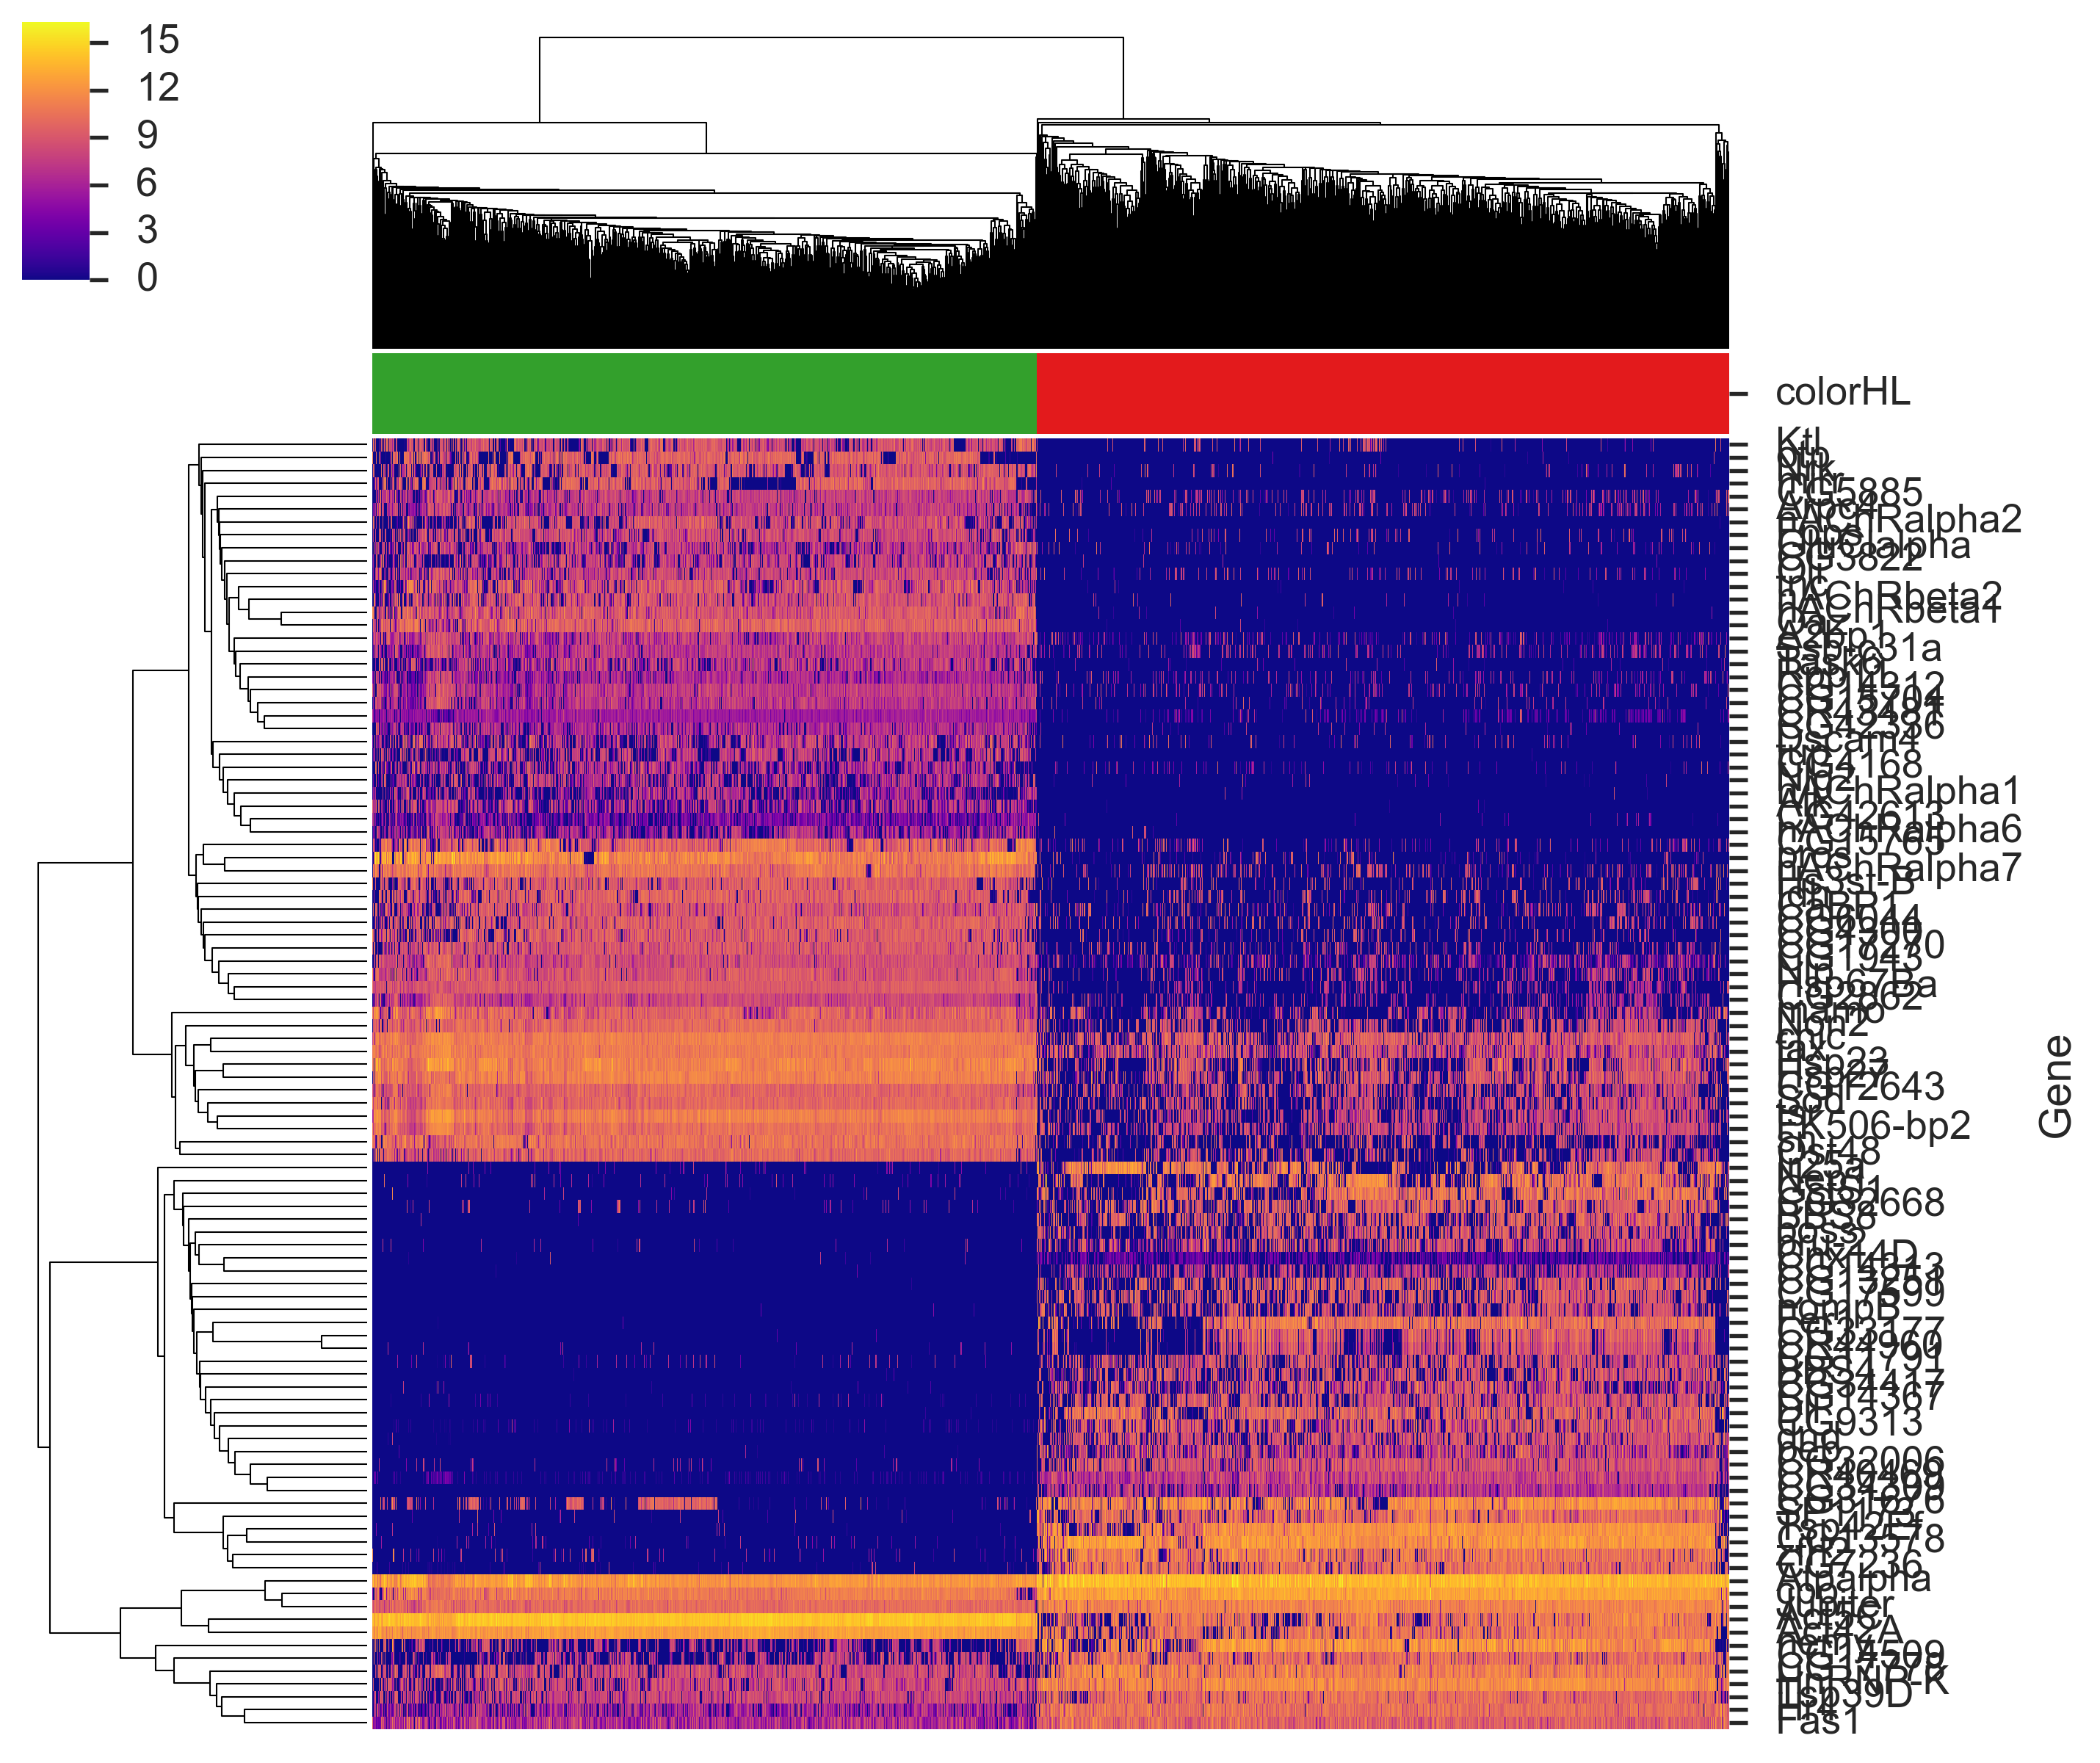

In [27]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,10), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../HL_Figures_paper/Fig_1/Fig1_ORN_PN_ClusterMap_top_100_DE_genes.pdf")

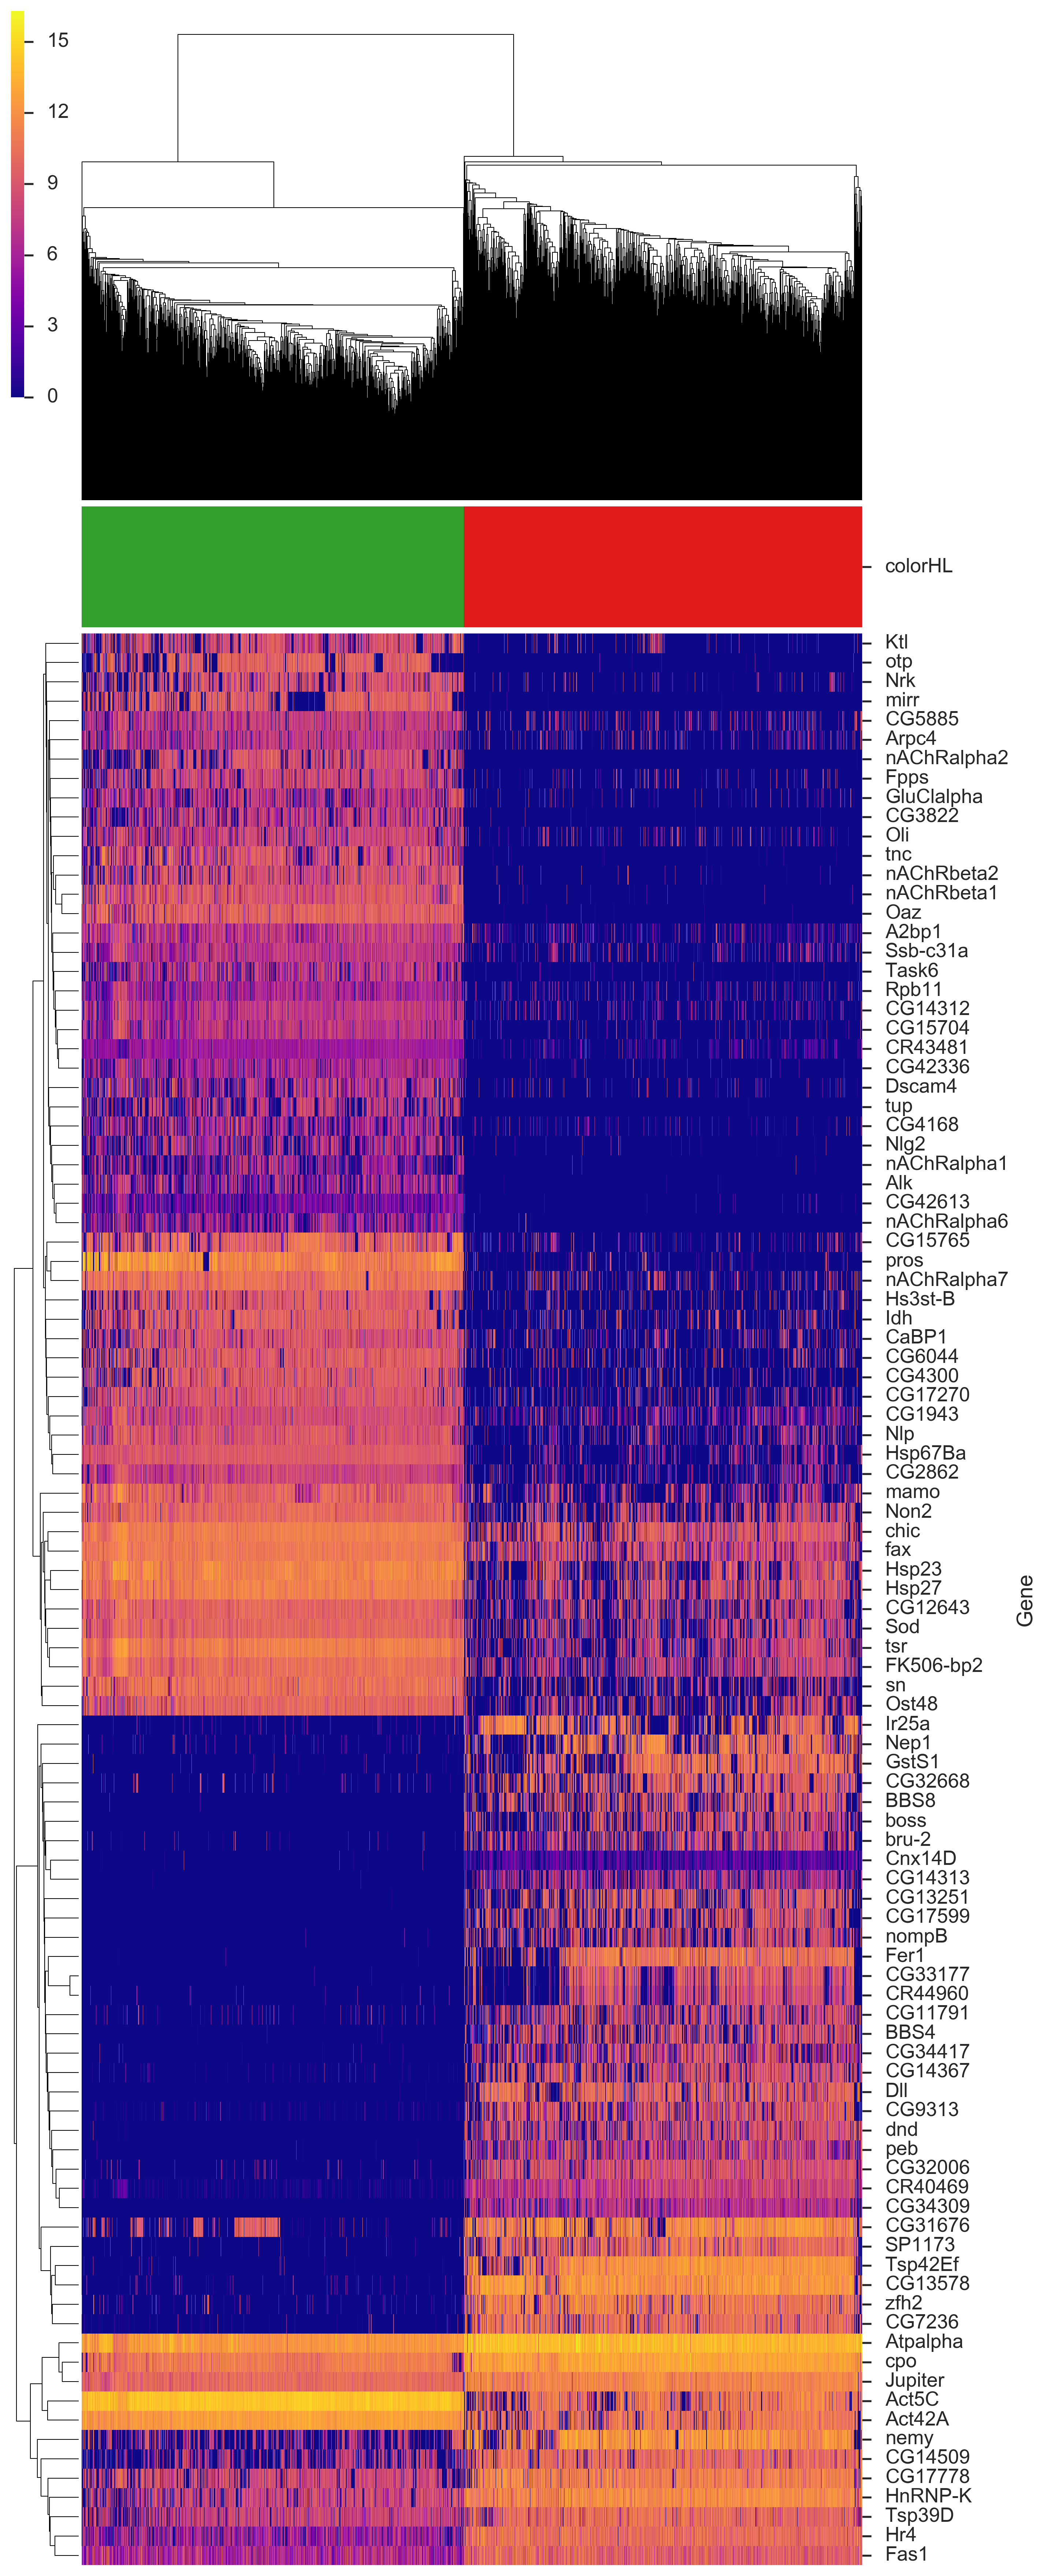

In [41]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,30), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../HL_Figures_paper/Fig_1/Fig1_ORN_PN_ClusterMap_top_100_DE_genes_long.pdf")

# Plot distribution of selected population

In [8]:
df_star = pd.read_csv("../data_paper/STAR.tab", sep="\t", header=0, index_col=0)
df_star.shape
#df_star

(4390, 6)

In [9]:
df_star_PN = df_star.loc[names_PN]
df_star_ORN = df_star.loc[names_All_ORN]
#df_star_85A10_ORN = df_star.loc[names_New_85A10_ORN_P4]
#df_star_AM29_ORN = df_star.loc[names_New_AM29_ORN_P4]

print "all PN:", df_star_PN.shape
print "all ORN:", df_star_ORN.shape
#print "85A10 ORN:", df_star_85A10_ORN.shape
#print "AM29 ORN:", df_star_AM29_ORN.shape


all PN: (976, 6)
all ORN: (1016, 6)


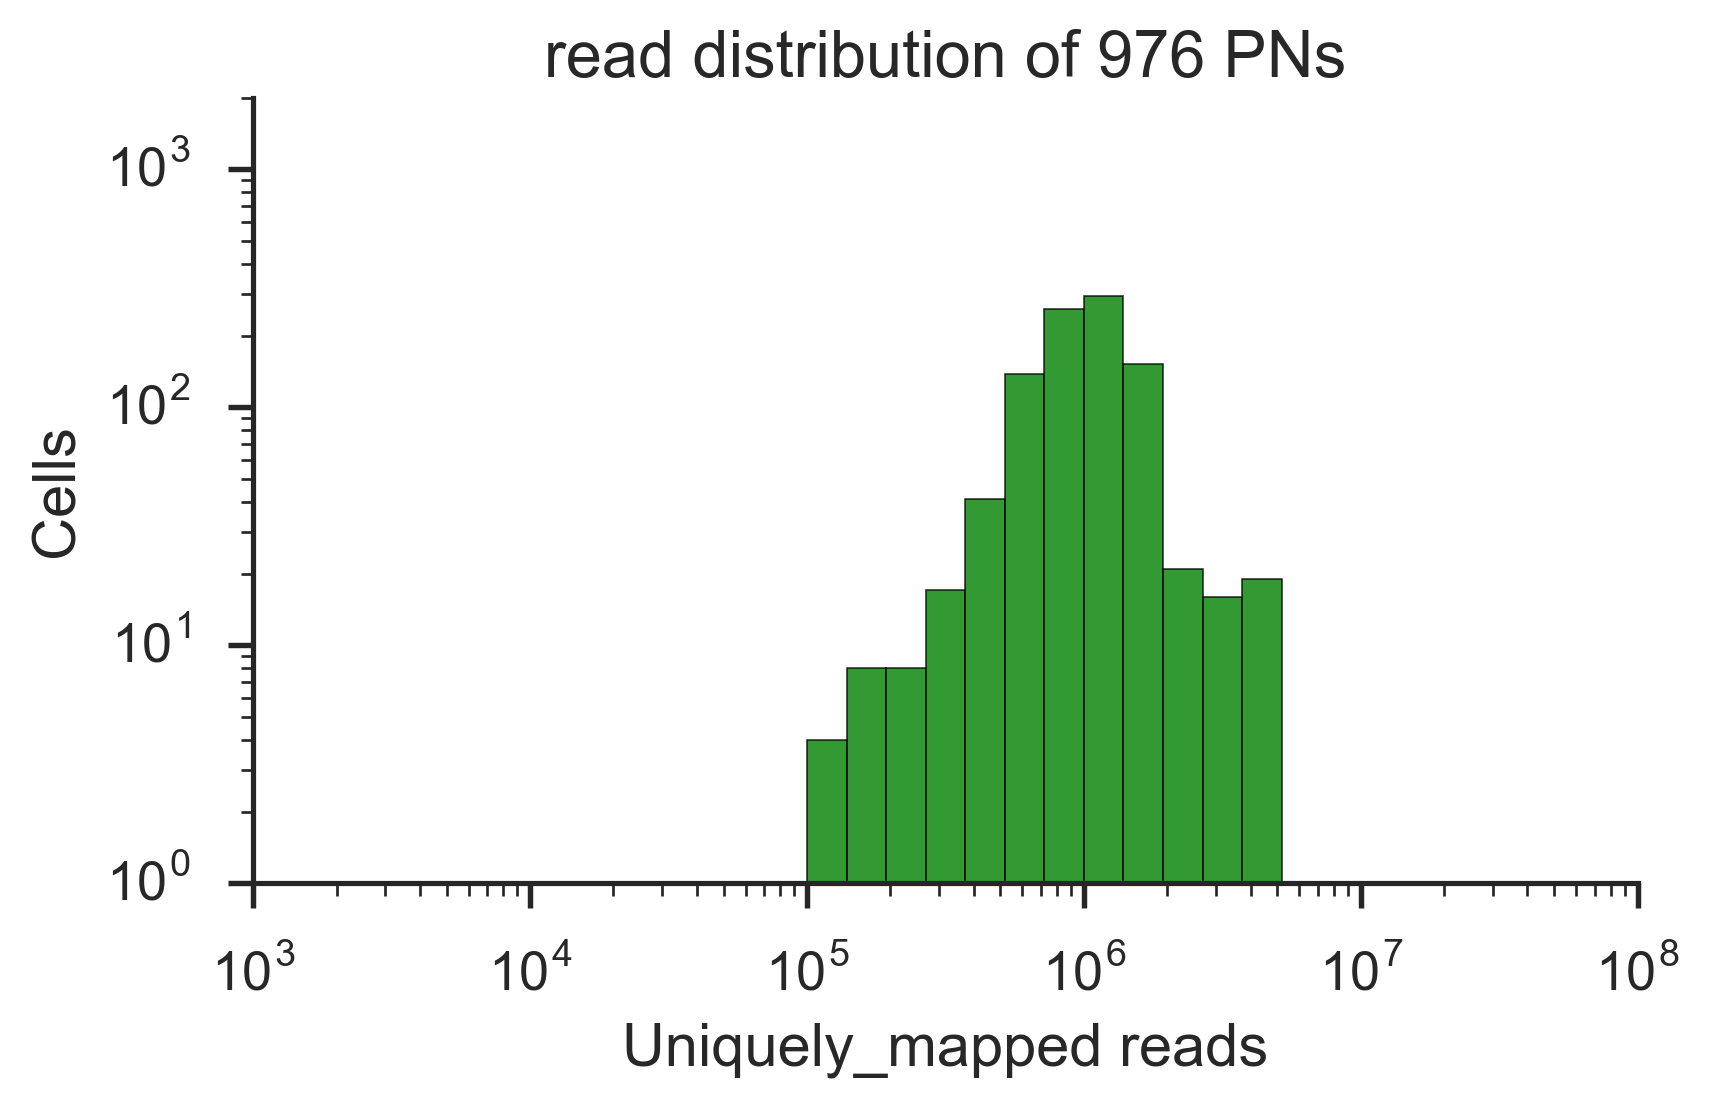

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df_star_PN["uniquely_mapped"], bins=np.logspace(0,7,50), color=['green'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'
plt.title("read distribution of 976 PNs")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1000, 1e8)
ax.set_xlabel("Uniquely_mapped reads")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../HL_Figures_paper/Fig_1/FigS1_reads_distribution_PN.pdf")

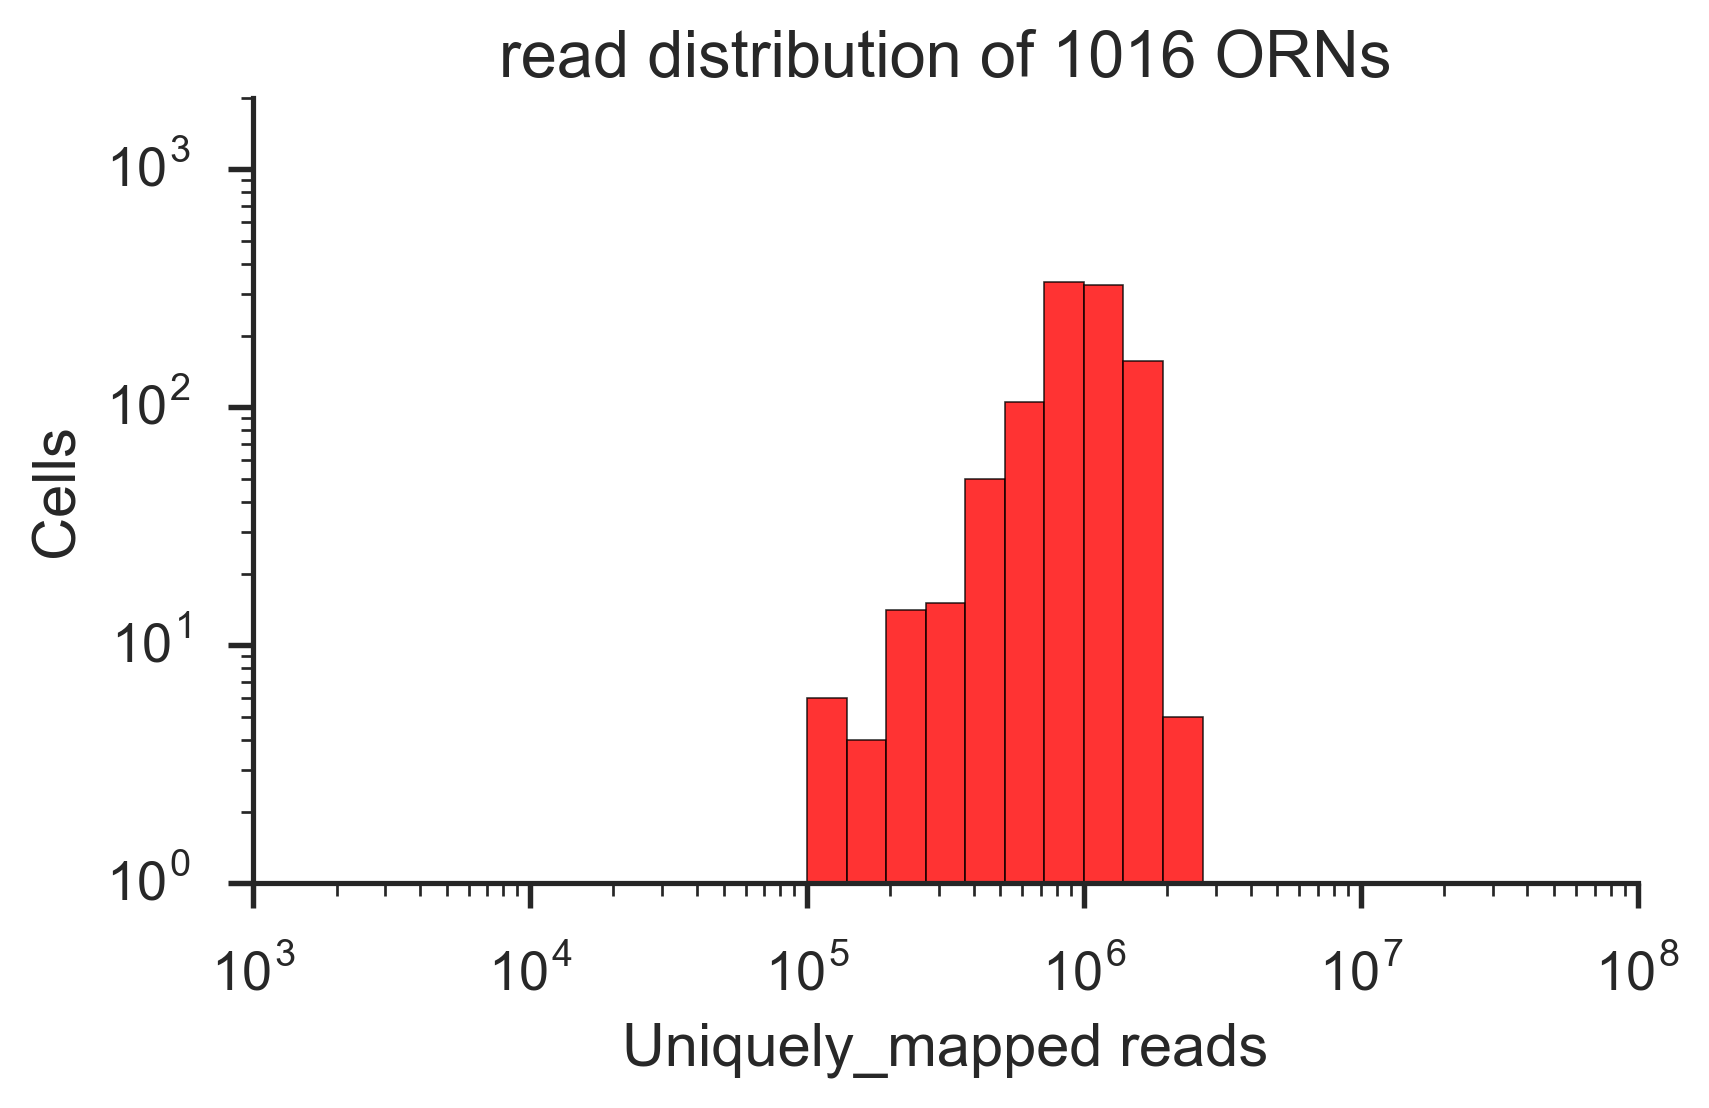

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df_star_ORN["uniquely_mapped"], bins=np.logspace(0,7,50), color=['r'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'
plt.title("read distribution of 1016 ORNs")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1000, 1e8)
ax.set_xlabel("Uniquely_mapped reads")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../HL_Figures_paper/Fig_1/FigS1_reads_distribution_ORN.pdf")

In [11]:
df = df_PN
df1 = df[df >= 3.0].count() #Log(CPM+1)>=2, CPM >= 3

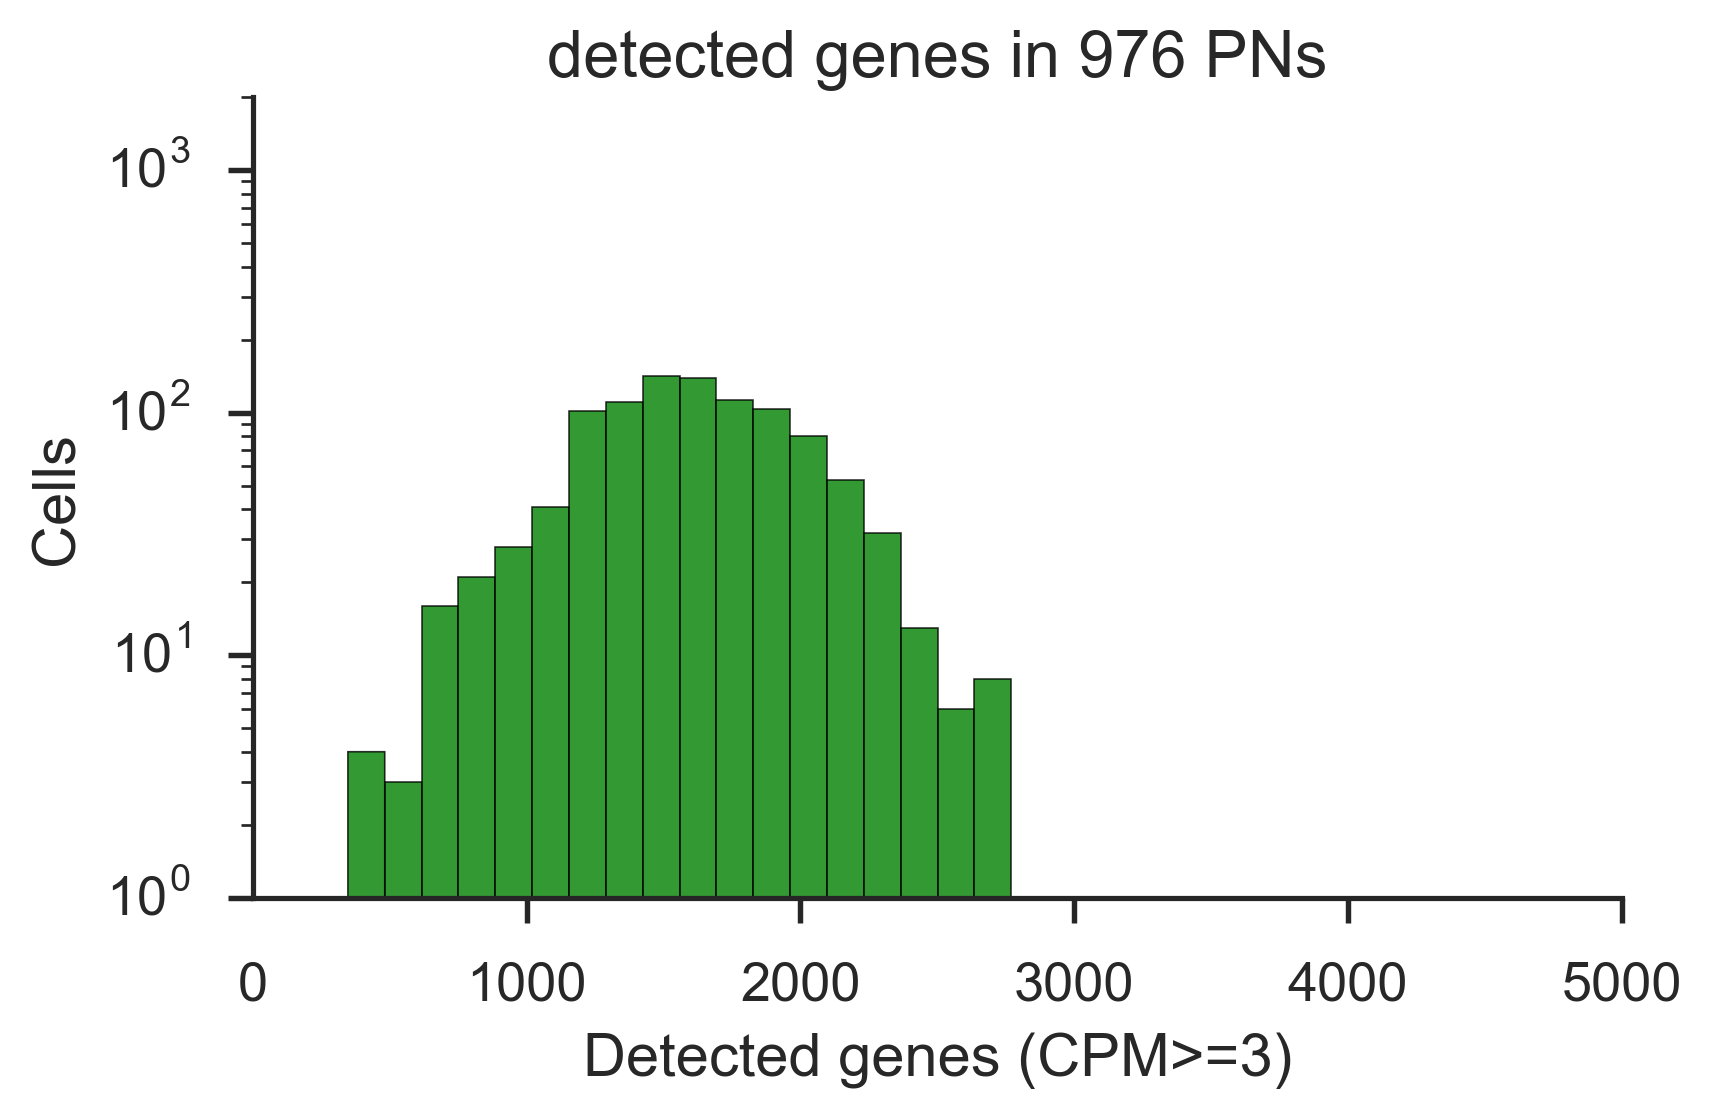

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df1, 18, color=['green'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'

plt.title("detected genes in 976 PNs")
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1, 5000)
ax.set_xlabel("Detected genes (CPM>=3)")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../HL_Figures_paper/Fig_1/FigS1_genes_detected_PN.pdf")

In [10]:
df = df_All_ORN
df1 = df[df >= 3.0].count() #Log(CPM+1)>=2, CPM >= 3

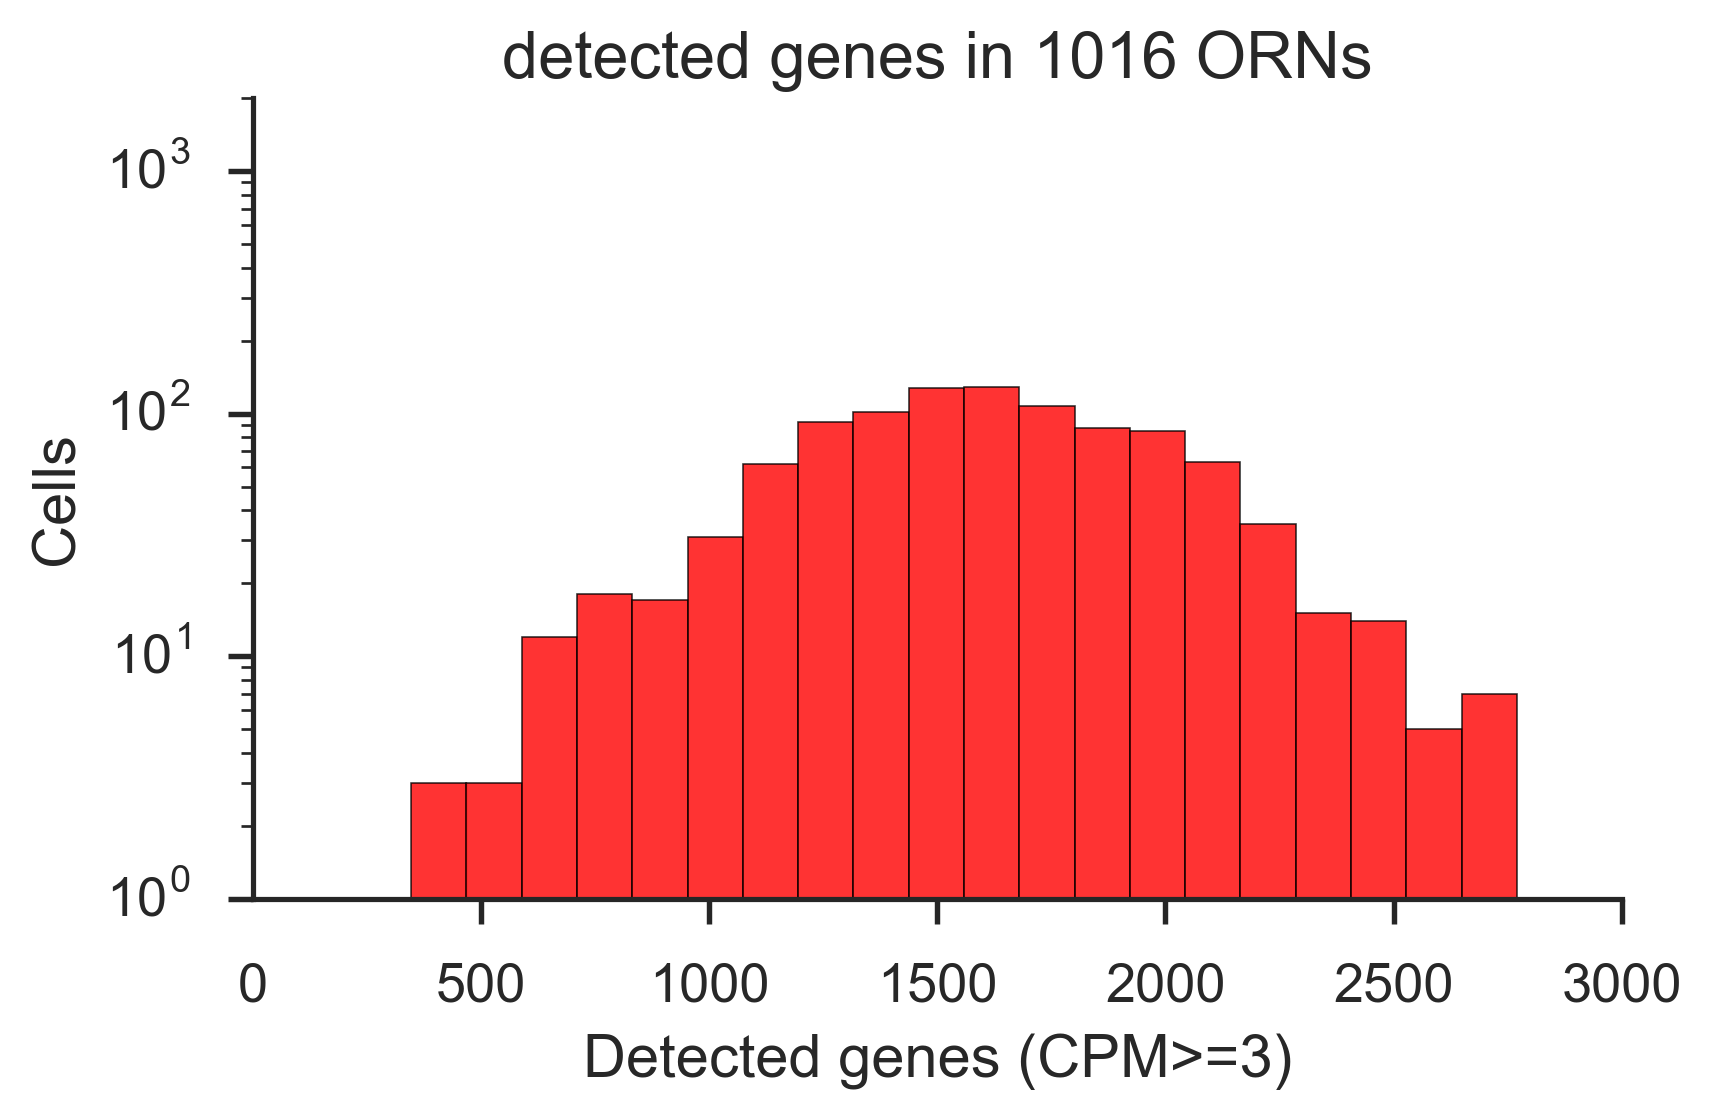

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df1, 20, color=['r'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'

plt.title("detected genes in 1016 ORNs")
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1, 3000)
ax.set_xlabel("Detected genes (CPM>=3)")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../HL_Figures_paper/Fig_1/FigS1_genes_detected_ORN2.pdf")

In [22]:
df_libs = pd.read_csv("../data/libs_color3.csv", sep=",", header=0, index_col=0) # sample info

# 2nd segment gene markers

In [8]:
X = df_All_ORN
X.shape

(15908, 1016)

In [47]:
#specific genes in 2nd segment of the antenna
MyGenes = ["Act5C","nSyb","Arr2","Pdh","Gbeta76C","CG1561","Rh4","se","retinin"]
MyGenes = ["mCD8-GFP","nSyb","Ir25a","Orco"]


Z = X.loc[MyGenes]

In [48]:
Z=Z.T
Z = Z.sort_values(by="Ir25a", axis=0, ascending=False)
Z=Z.T
Z

N510Barcode_726-515  N510Barcode_702-522  N543Barcode_704-506  \
symbol                                                                    
mCD8-GFP            13.905587            13.090684            13.710743   
nSyb                11.312536             8.765238            12.255194   
Ir25a               13.558659            13.526354            13.431329   
Orco                 0.000000             0.000000             0.000000   

          N509Barcode_710-510  N510Barcode_702-515  N447Barcode_726-516  \
symbol                                                                    
mCD8-GFP            13.694299            13.728319            10.696854   
nSyb                 8.614775            11.036097            11.008795   
Ir25a               13.320085            13.198308            13.192771   
Orco                 0.000000             0.000000             0.000000   

          N543Barcode_706-522  N509Barcode_712-510  N447Barcode_715-518  \
symbol                                                                    
mCD8-GFP            11.097981            13.422342            13.603416   
nSyb                11.052436            10.631442            12.138500   
Ir25a               13.187792            13.164940            13.146761   
Orco                 0.000000             0.000000             0.000000   

          N510Barcode_722-522         ...           N510Barcode_721-506  \
symbol                                ...                                 
mCD8-GFP            12.926850         ...                     12.274514   
nSyb                11.293823         ...                      1.113620   
Ir25a               13.064725         ...                      0.000000   
Orco                 0.000000         ...                      0.000000   

          N509Barcode_726-511  N510Barcode_721-508  N510Barcode_721-511  \
symbol                                                                    
mCD8-GFP            14.562834            11.857301            11.543843   
nSyb                10.871181            10.499378            10.705400   
Ir25a                0.000000             0.000000             0.000000   
Orco                 0.000000             0.000000             0.000000   

          N509Barcode_726-507  N510Barcode_721-521  N510Barcode_722-508  \
symbol                                                                    
mCD8-GFP            13.030909            12.334953            11.978116   
nSyb                 9.685729            11.719255            10.666784   
Ir25a                0.000000             0.000000             0.000000   
Orco                 0.000000             0.000000             0.000000   

          N509Barcode_724-520  N510Barcode_722-517  N447Barcode_701-503  
symbol                                                                   
mCD8-GFP            10.650523            12.503289            12.334993  
nSyb                10.128945             9.572697             8.365312  
Ir25a                0.000000             0.000000             0.000000  
Orco                 0.000000             0.000000             0.000000  

[4 rows x 1016 columns]

In [44]:
a = len(Z.loc['Ir25a'].index)
sum(i >= 3 for i in Z.loc['Ir25a'])/a

0.62204724409448819

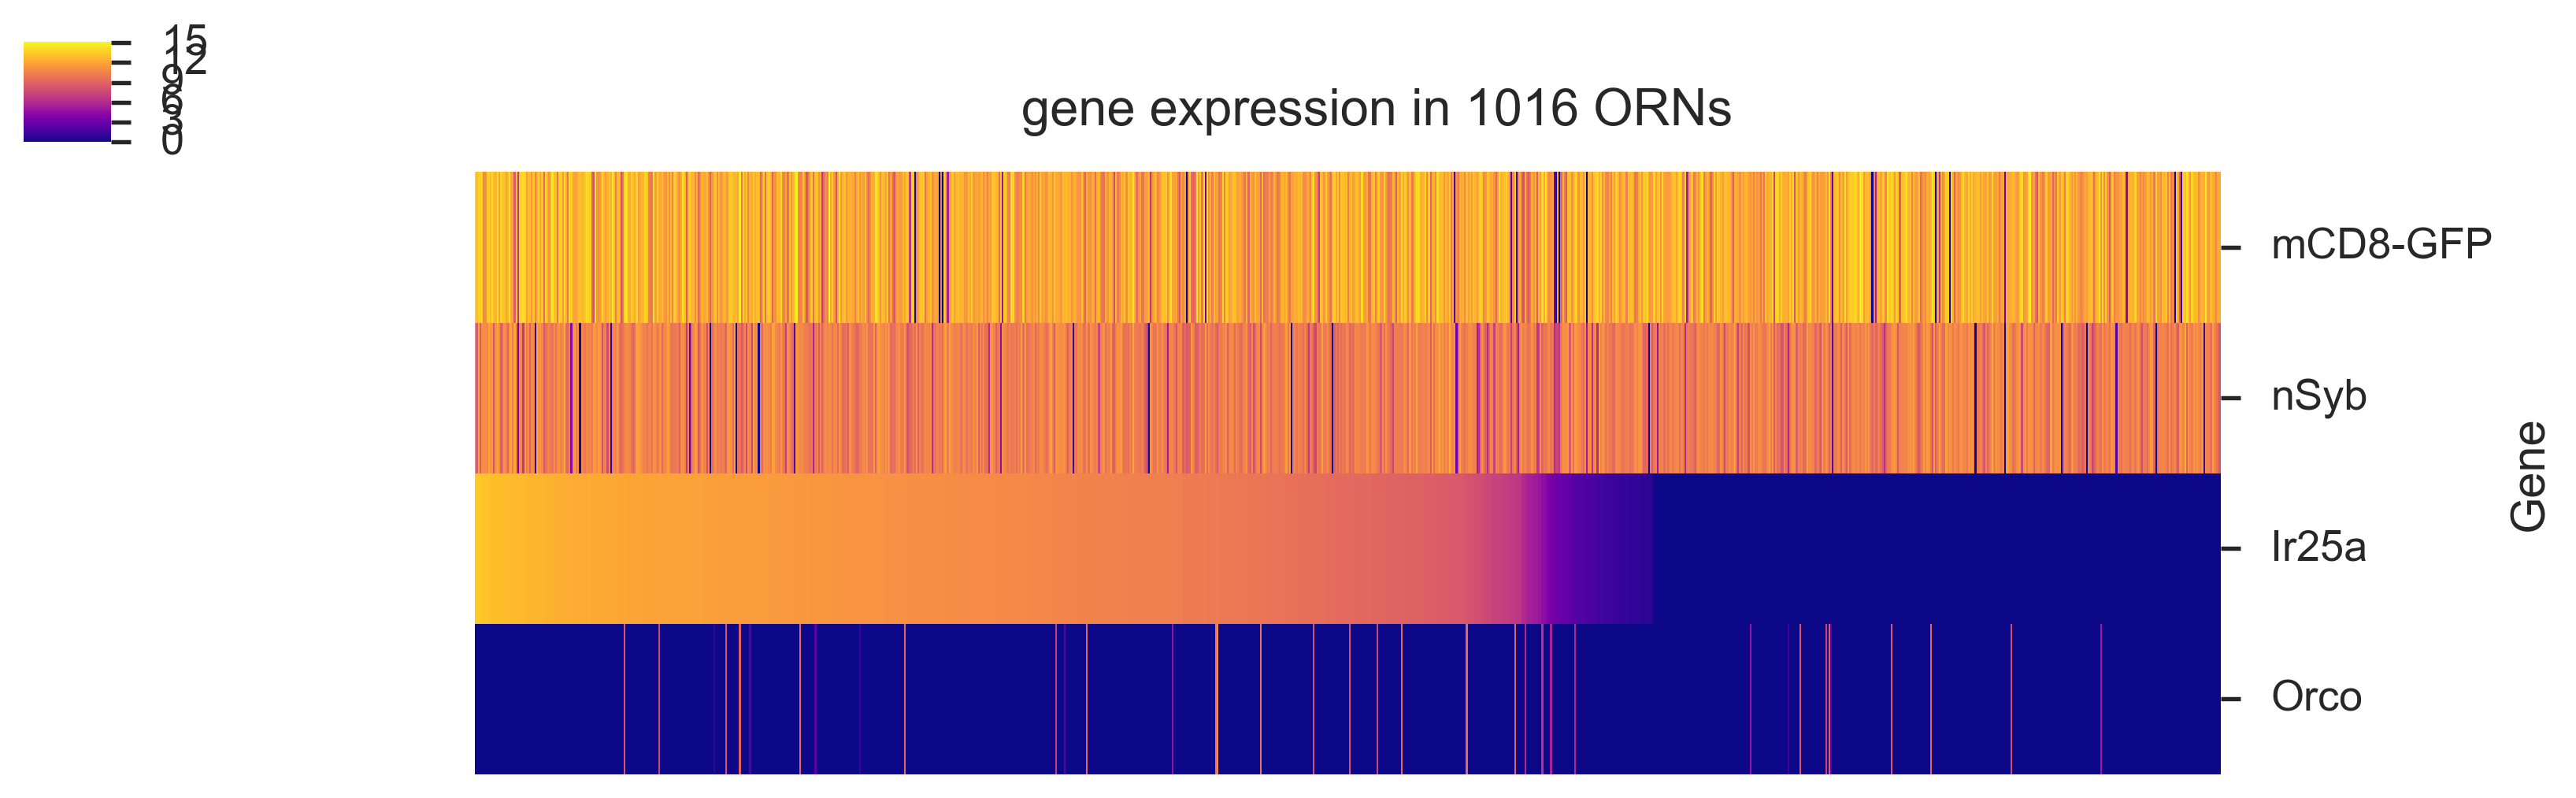

In [49]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(12,4), row_cluster=False, col_cluster=False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title("gene expression in 1016 ORNs", x=15.5, y= 0.01)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../HL_Figures_paper/Fig_1/FigS1_heatmap_ORN_Ir25a_orco.pdf")

# Selected genes to display

In [26]:
df_libs = pd.read_csv("../data/libs_color3_PN_ORN.csv", sep=",", header=0, index_col=0) # sample info

In [39]:
genes_1 = ["roX1","roX2"]
#ten-a high: DA1, Or67d; ten-m high: VA1d, Or88a, VA1v, Or47b
Z = df_All_ORN.loc[genes_1]
Z= Z.T
Z = Z.sort_values(by = ["roX2","roX1"], ascending=False)
Z= Z.T

In [40]:
Z.shape

(2, 1016)

[]

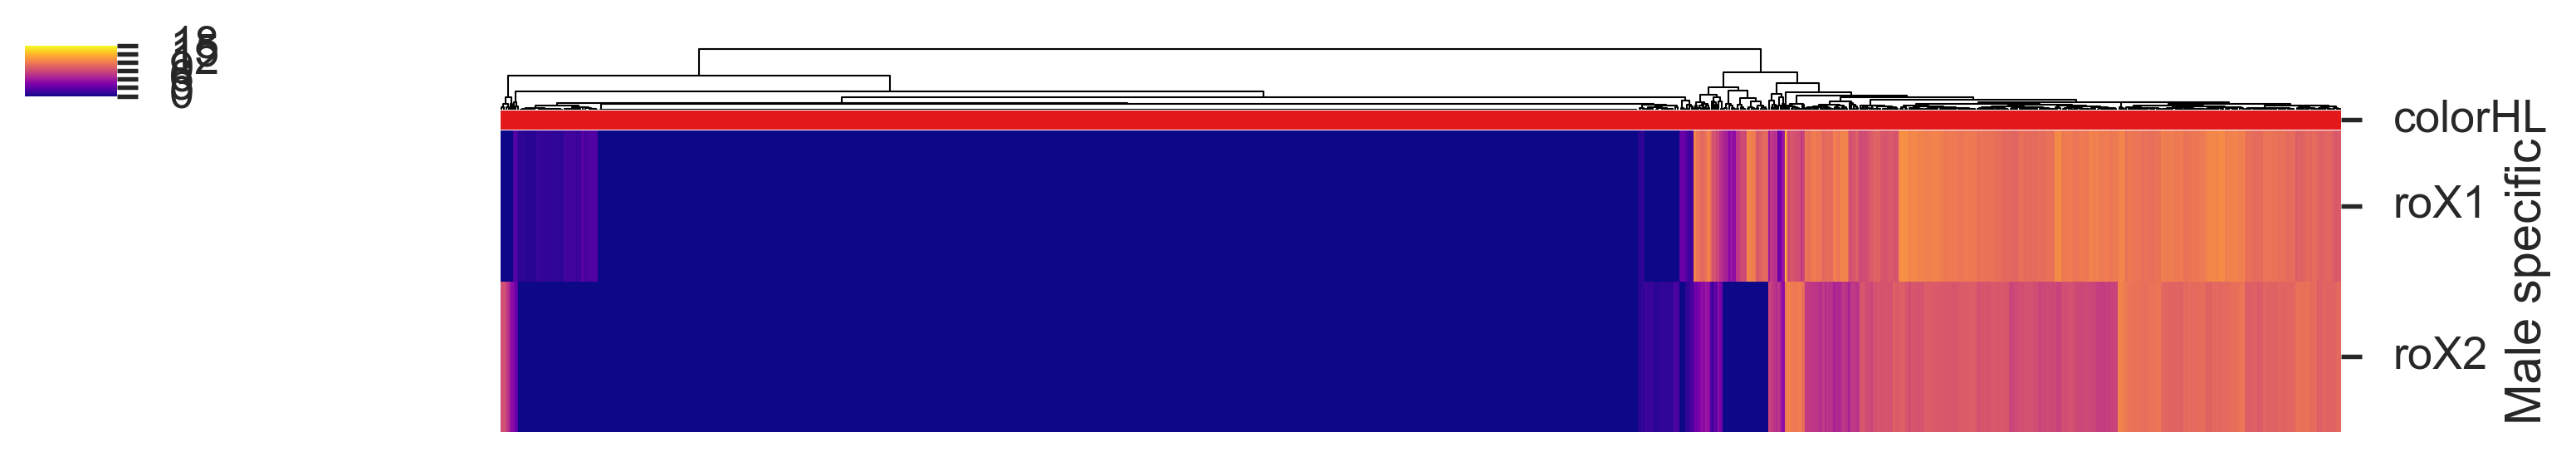

In [44]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", vmin=0, vmax=18, figsize=(12,2), col_colors=col_colors, row_cluster=False, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Male specific")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
#cm.savefig("../HL_Figures_paper/Fig_1/FigS1_heatmap_ORN_roX1_2.pdf")

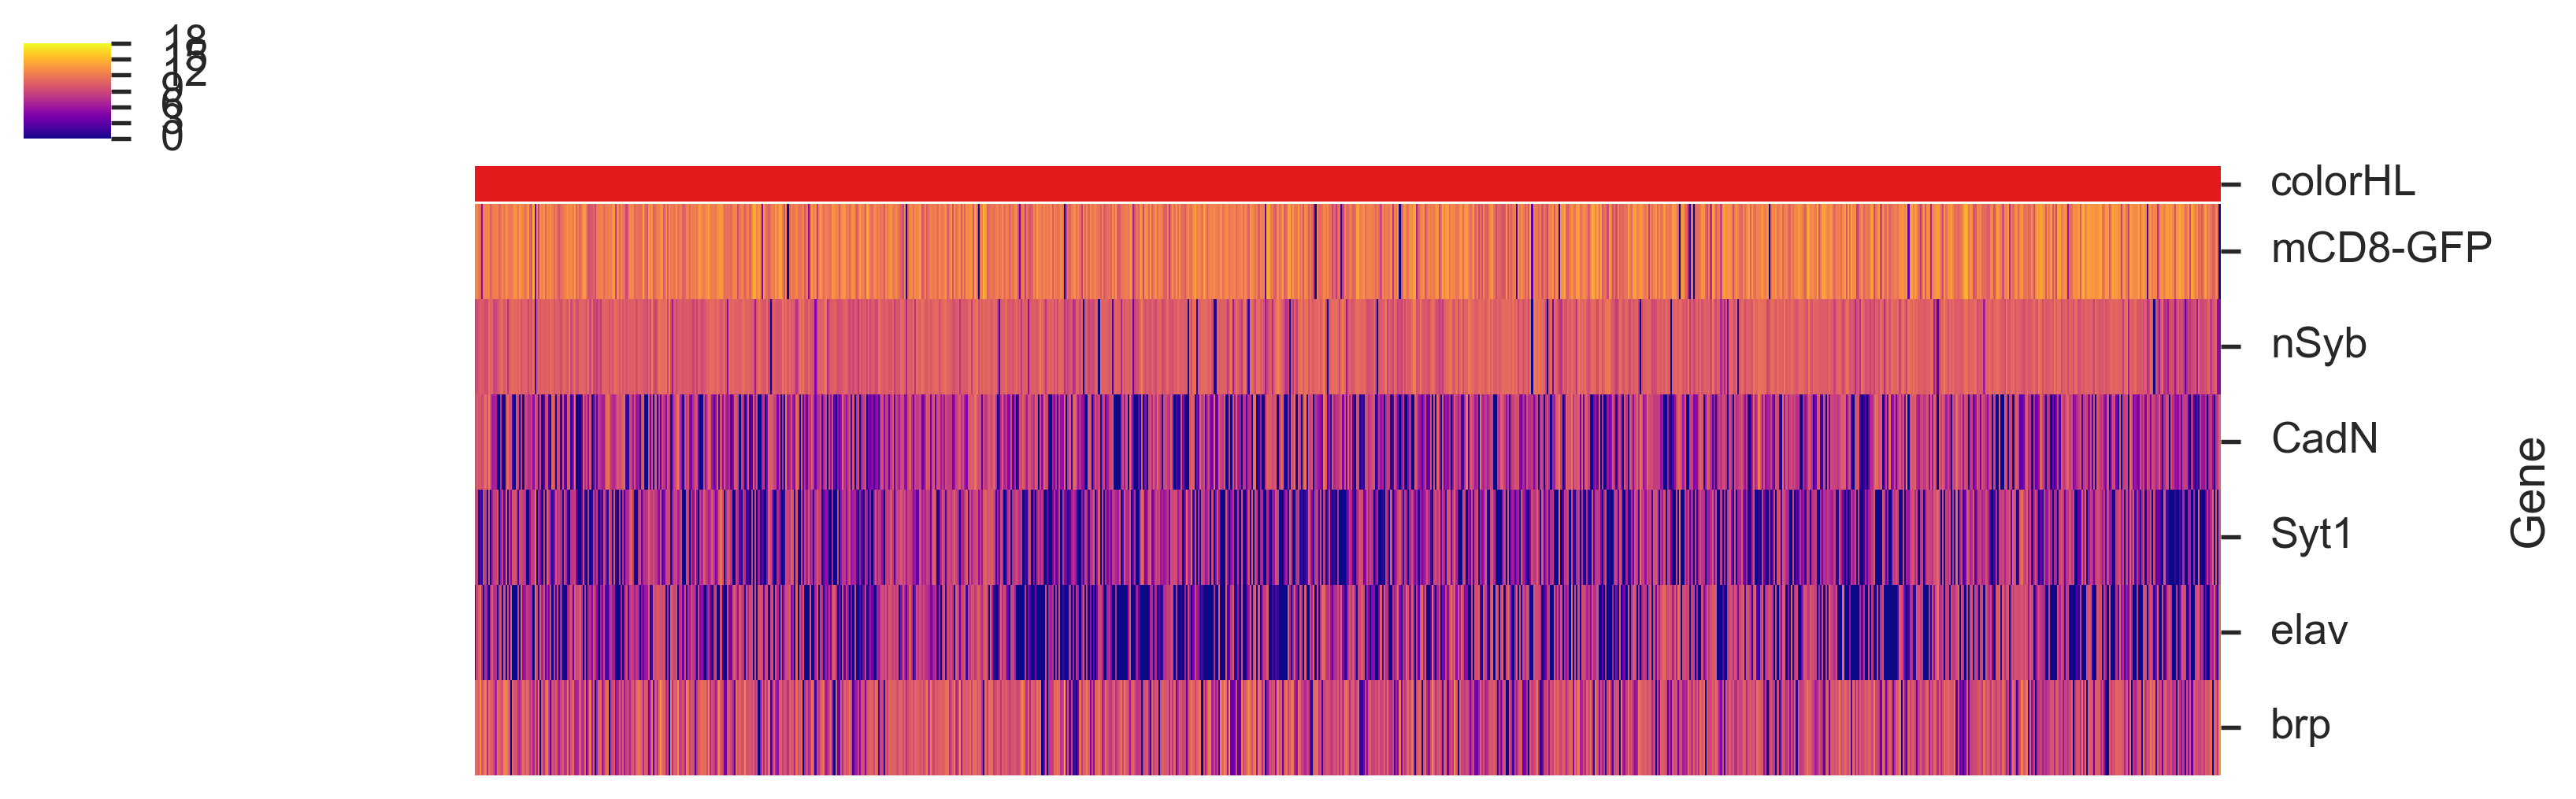

In [51]:
# Checke the neuronal makers and GFP
genes_1 = ["mCD8-GFP","nSyb","CadN","Syt1","elav","brp"]
#ten-a high: DA1, Or67d; ten-m high: VA1d, Or88a, VA1v, Or47b
Z = df_All_ORN.loc[genes_1]

# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", vmin=0, vmax=18, figsize=(12,4), col_colors=col_colors, row_cluster=False, col_cluster=False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../HL_Figures_paper/Fig_1/FigS1_heatmap_ORN_Neuronal makers.pdf")